# Stochastic Variational Inference

When it comes to Bayesian Inference, the general purpose tool is almost always MCMC or another marginalization / integration engine: some method to explore parameter space and map out likelihood contours with no a-prior knowledge of the _shape_ of these contours. Of course, in many practical cases we _do_ have prior knowledge of the distribution shape, at least in the broad sense. In a given problem we may know that one or the paramters will more than likely be constrained to, for example, correlated gaussians, or indepedent exponentials, or some other mix of the various "cannonincal" distributions. In such casess, we can leverage this knowledge of the "shape" of the posterior distribution to instead find a good approximation for a simplified, "good enough", distribution. This method has broadly been named _Variational Inference_, and the general-case method has come ot bear the name of **Stochastic Variational Inference** (SVI).

The general idea of SVI is to have some complicated posterior distribution, $p(z)$, and approximate it with some simple "surrogate distribution", $q(z \vert \phi)$, which is 'similar' to $p(z)$. Here, $\phi$ are tuneable variables of our surrogate distribution (_not_ model parameters) e.g. the mean and width of a normal distribution. The name "variational inference" comes from the method's pen-and-paper origins in functional analysis, but a more informative name might be something like "Surrogate Distribution Optimization of Parameters", as our goal is to find the $\theta$ that makes $q_{\theta}(z)$ fit $p(z)$ as closely as possible. 

The core benfit of SVI is that we turn the _integration_ problem of grid-search or MCMC into an _optimization_ problem. Optimizations problems scale better with dimension and are easier to run, and so we can use SVI to get (at the cost of precision) good speed up on any number of high dimensional problems.

**Contents**
- [Underlying Theory](#theory)
- [Doing SVI in NumPyro](#numpyro)
    - [Fitting Approximate Models](#approximate_models)
- [Interpreting Results](#interpreting)
    - [Getting MCMC-Like Chains out of SVI](#predictive_MCMClike)
	- [Generating Mock Observations](#mock_observations)
	- [Checking for Covergence](#convergence)
- [Some Small Examples](#small_examples) 
    - [Building Non-Trivial SVI Guides](#mixtures)
    - [Automatic Guide Generation](#autoguides)
- [A Practical Example - Linear Regression with Outliers](#Example_1)
- [Another Practical Example - SVI in Higher Dimensions](#Example_2)
    - [Non-Gaussian Autoguide](#Example_2_non_gaussian) 

## How it Works <a id='theory'></a>

In SVI, we seek to tweak the tuning variables $\phi$ of our surrogate model $q_{\phi}(z)$ until it is a close match to the true posterior $p(z)$, but how exactly do we define the two distributions to be 'similar'? The traditional method in SVI to use to use the **Kullback–Leibler Divergence** (KLD) between the two distributions:

\begin{equation}
    KL_{p \rightarrow q_{\theta}} 
    = \mathbb{E_{q_{\theta}}} \left[ \ln \lvert \frac{q_{\theta}(z)}{p(z)} \rvert \right]  
    = \int{   q_{\theta}(z) \ln \lvert \frac{q_{\theta}(z)}{p(z)} \rvert } dz
\end{equation}

The KL Divergence also shows itself in discussions about the "information" or "entropy" of distributions, measures of how well they constrain parameters, but in this case we can just think of it as a measure of the "distance" we seek to minimize between our two distributions. It's worth noting that $KL=0$ when $q_{\theta}(z) = p(z)$, which tells us that KL is strictly positive: $KL \ge 0$. In most applications, we don't _actually_ have access to the normalized posterior distribution $p(z)$, and instead will have it in the un-normalized form that we normally perform MCMC on. We can evaluate the "shape" of the posterior, but only up to its normalizing constant / evidence '$Z$':

$$
    P(z) = \pi(z) \cdot \mathcal{L}(z) = Z p(z), \;\; Z = \int{P(z)}dz
$$

Having the evidence is basically the same as having already solved for $p(z)$, and so we want to express the KL divergence in a way that it can be minimized without knowing $Z$:

\begin{eqnarray}
    KL_{p \rightarrow q_{\theta}} 
    = & \mathbb{E_{q_{\theta}}} \left[ \ln \lvert \frac{P(z)}{q_{\theta}(z)} \rvert \right] + \mathbb{E_{q_{\theta}}} \left[ \ln \lvert Z \rvert \right]\\
    = & -\text{ELBO} + \ln \lvert Z \rvert \\
\end{eqnarray}

Here we've defined the **Evidence Lower Bound** (ELBO), an evidence-free proxy for the KL-divergence. Rather than "minimzing the KL-divergence", we speak in terms of "maximizing the ELBO", to the same end. The name comes from the fact that it acts as a lower bound for the _true_ posterior's log-evidence:

\begin{equation}
    0 \le KL_{p \rightarrow q_{\theta}}  = -\text{ELBO} + \ln \lvert Z \rvert  
    \;\; \rightarrow \;\; 
    \text{ELBO} \le \ln \lvert Z \rvert
\end{equation}

This is the core of SVI: we optimize the surrogate model's tuning parameters to maximize the ELBO. There are some special-case versions of SVI with analytical solutions, but in NumPyro terms this is a pure numerical optimziation problem, well suited to JAX's autodiff. Obviously, $\text{ELBO} = \mathbb{E_{q_{\theta}}} \left[ \ln \lvert \frac{q_{\theta}(z)}{P(z)} \rvert \right]$ is an expectation value and still requires some integration over $q_{\theta}(z)$. This is done via Monte-Carlo integration, hence the "stochastic" part of "stochastic variational inference". Because we're only using it to navigate instead of defining the entire distribution, this integral can afford to be sparsely sampled without breaking our engine.

The broad overview of SVI is then:
 1. Choose a surrogate distribution form that approximates the true posterior after some tuning
 2. Use monte carlo integration to estimate the ELBO (and its gradients with respect to $\theta$)
 3. Using numerical optimization, tweak $\theta$ until the ELBO reaches a stable maximum


![image](EXAMPLEGRAPH.png)

-----

## Doing SVI in NumPyro <a id='numpyro'></a>
NumPyro has ready-made tools for doing SVI without much more complexity than an MCMC run. As a quick overview, an SVI job consistent of four components:

1. A standard NumPyro model that can generate a posterior and defines latent variables in the form of `numpyro.samples`
2. A numpyro "guide" that defines surrogate sample distributions in in terms of the optimizeable `numpyro.parameters`
3. A JAX optimizer from the `numpyro.optim` module
4. And a `numpyro.infer.SVI`object that takes in all of the above to perform the SVI run. This is analagous to the `numpyro.infer.MCMC` object we use in MCMC, a "handler" for our various objects and results

After running the SVI job, we can use the optimized surrogate distribution to generate recover MCMC chain-like sets of points in parameter space or to make mock data corresponding to these points.

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

import jax.numpy as jnp
import jax, jaxopt
from jax import random

import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

/home/hughmc/anaconda3/envs/nestconda_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Heads or Tails: A Simple Model
As a first example, we'll go over a variation of the the heads / tails example from the [old pyro documentation](http://pyro.ai/examples/svi_part_i.html) and the modern (but incomplete) equivalent from the [NumPyro documentation](https://num.pyro.ai/en/stable/svi.html). The basic setup is simple: we have a coin being tossed a certain number of times, landing heads $A$ times and tails $B$ times in no particular order. We're seeking to constrain the "fairness" of the coin, '$f$', the probability of it landing heads on any given flip.

This problem has a well known analytical solution: the PDF for $f$ is given by a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), a close cousin to the binomial distribution, but giving the probability of the fairness rather than the number of events:

\begin{equation}
    \beta(f,A,B) = \frac{1}{C}  f^{A-1}\cdot f^{B-1}
\end{equation}

Where the normalizing constant $C$ is given in terms of Gamma Functions:

\begin{equation}
    C = \frac{\Gamma(A+B)}{\Gamma(A) \Gamma(B)}
\end{equation}

The beta distribution has known mean and variance:

\begin{equation}
    \text{mean}(\beta) = \frac{A}{A+B} \;\;\;\;
    \text{var}(\beta) = \frac{AB}{(A+B)^2 (A+B+1)}
\end{equation}

And, in the limit $\lim_{A,B} \rightarrow \infty$, converges to a normal distribution with:

\begin{equation}
    \text{mean}(N) = \frac{A}{A+B} \;\;\;\;
    \text{var}(N) = \frac{\text{mean}(N)\cdot(1-\text{mean}(N))}{A+B}
\end{equation}

In this example, we'll model the data with a binomial distribution, and then use SVI to fit a $\beta$ distribution to $f$, and use SVI again to instead fit an approximate gaussian.

**Generating Data & Model** <a id='approximate_distributions'></a>

First we generate some test data. In our case, this is a series of coin flips with $A=12$ heads and $B=8$ tails, so the maximum likelihood is $\hat{f}=60\%$:

In [2]:
# Actual head and tails
A_true, B_true = 12, 8 
data_headstails = jnp.concatenate([jnp.ones(A_true), jnp.zeros(B_true)])

# Mean & Var
mean_true, var_true = A_true/(A_true + B_true), (A_true*B_true / (A_true + B_true)**2 / (A_true + B_true+1))**0.5

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


For a given fairness, the probability of any coin toss landing heads or tails follows a [bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), such that the entire run of heads and tails follows a binomial distribution:

\begin{equation}
    p(f \vert A,B) \propto \prod_A \text{Bernoulli}(f) \cdot \prod_B \text{Bernoulli}(1-f)
\end{equation}

And we can construct this as a model in numpyro:

In [3]:
def model_headstails(data):
    '''
    'f' is the fairness of the coin flip, with a uniform prior
    '''
    # Uniform prior on fairness
    f = numpyro.sample("latent_fairness", dist.Uniform(0, 1))

    # Each coin toss has an f:1-f chance of landing heads / tails:
    with numpyro.plate("N", data.shape[0] if data is not None else 10): # Second half used for generating mock data later
        # Now acquire the likelihood of getting `data` if 'f' was accurate
        numpyro.sample("obs", dist.Bernoulli(f), obs=data)

**Fitting A Beta Distribution with SVI**

Now onto the actual SVI work. The biggest difference between MCMC and SVI in NumPyro is the '_guide_', a python function that tells numpyro about the  surrogate distribution and what variables we tune such that this distributions minimizes the ELBO. Unlike numpyro models, guides include non-stochastic variables that are used for optimization instead of sampling / integration. These parameters are identified by variables marked as `numpyro.param`, while the model latent variables are all `numpyro.samples`, with the `samples` being drawn from distributions that depend on the `params`.

In this part, we'll construct a guide for a generic $\beta$ distribution, which has two `params` to optimize: $A$ and $B$. Notice that we apply constraints on the variables, in this case defining that $A,B>0$. All constraints come from `numpyro.distributions.constraints`, and you can find a full list in the [NumPyro documentation](https://num.pyro.ai/en/stable/_modules/numpyro/distributions/constraints.html). We also need to specify an initial value for the optimization to begin at, taking care to ensure this value doesn't violate these constraints:

In [4]:
def guide_beta(data):
    '''
    The 'guide' describes the set of surrogate functions we can approximate likelihood function with
    In this case, surrogate functions are the family beta(f,A,B).
    '''
    alpha_q = numpyro.param("alpha_q", # Site Name
                            20.0/2.0, # Initial value in optimization
                            constraint=constraints.positive) 
    beta_q = numpyro.param("beta_q", 
                           20.0/2.0,  # Note that this init value _needs_ to be a float as its a continuous param
                           constraint=constraints.positive)
    
    numpyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

Now the fun part: we construct an `SVI` object just like we would an `MCMC` object: feeding it the statistical modelling (in his case a model and guide) and a solution method (in this case an optimizer and a loss function). The loss being given as `Trace_Elbo()` just refers to us minimizing the KL divergence in a model with entirely continuous variables, something we won't need to touch in most cases. We also make an `Adam` optimizer, `JAX`'s native autodiff-based stochastic optimization routine that will let the `SVI` object navigate to the best $\theta$.

We fire this off with `.run()`, and collect our results just as we would with an MCMC run:

In [5]:
# Make a JAX optimizer
optimizer = numpyro.optim.Adam(step_size=0.0005)

# Make and run the SVI object
svi_beta = SVI(model_headstails, guide_beta, optimizer, loss=Trace_ELBO())
svi_beta_result = svi_beta.run(random.PRNGKey(1), num_steps = 10000, data = data_headstails)

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4593.88it/s, init loss: 18.0005, avg. loss [9501-10000]: 14.7887]


The optimal `param` values are stored as a keyed dictionary in the `svi_beta_result` object, and we can extract these to see our best fit surrogate model. In this instance, we know both the ground truth for the parameters _and_ an analytical solution for the pdf of $f$, and so we can see how well SVI has done at recovering the true distribution. We can see that SVI has, in short order, recovered the parameters to within $\approx 10 \%$, and has similarly recovered import summary statistics like the mean and variance of the pdf:

----------------------------------------------------------------------------
	 Truth 	 SVI
A 	 12.0 	 12.3
B 	 8.0 	 8.6
Mean 	 0.60 	 0.59
Var 	 0.11 	 0.11
----------------------------------------------------------------------------


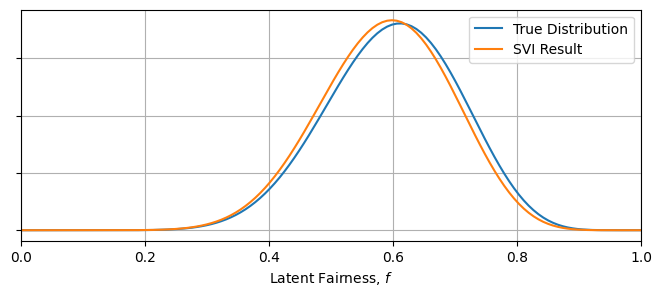

In [6]:
from scipy.stats import beta, norm

#----------------------------------
params_beta = svi_beta_result.params
A_beta, B_beta = params_beta["alpha_q"], params_beta["beta_q"]

# Get Mean & Var of beta(A,B) for A,B recovered by SVI
inferred_mean = A_beta / (A_beta + B_beta)
inferred_var  = (A_beta * B_beta / (A_beta + B_beta)**2 / (A_beta + B_beta+1))**0.5

#----------------------------------
print("-"*76)
print("\t Truth \t SVI")
print("A \t %0.1f \t %0.1f" %(A_true, params_beta["alpha_q"]))
print("B \t %0.1f \t %0.1f" %(B_true, params_beta["beta_q"]))
print("Mean \t %0.2f \t %0.2f" %(mean_true, inferred_mean))
print("Var \t %0.2f \t %0.2f" %(var_true, inferred_var))
print("-"*76)
#----------------------------------

Xplot = np.linspace(0,1,128)
plt.figure(figsize = (8,3))
plt.plot(Xplot, beta(A_true,B_true).pdf(Xplot), label = "True Distribution")
plt.plot(Xplot, beta(params_beta["alpha_q"], params_beta["beta_q"]).pdf(Xplot), label = "SVI Result")
plt.xlim(0,1)
plt.gca().yaxis.set_ticklabels([])
plt.xlabel("Latent Fairness, $f$")
plt.grid()
plt.legend()

plt.show()

**Fitting Approximate Models with SVI** <a id='approximate_models'></a>

In our simple toy model, we were able to define a guide that, if properly optimized, SVI recovers the _exact_ solution of the $\beta$ distribution. We rarely enjoy this luxury in the real world, as cases with analytical solutions aren't really the use case for numerical statistical methods. A more realistic use case for SVI is in fitting a simplified surrogate model that emulates a reasonable fit to the posterior without matching it exactly. In a lot of applications we crunch the posterior down to a mean and standard deviation anyway, and so we can imagine a "best fit gaussian" as being a useful tool.

As an example in our heads / tail case, we can see that $\beta$ distributions are _almost_ gaussian for large numbers of trails, and so we might consider using SVI to fit a normal distribution instead. As before, we define a guide that describes the set of all surrogate distributions, this time tuning the mean and standard deviation of our gaussian:

In [7]:
def guide_normal(data):
    mean = numpyro.param("mean", 
                            0.5, 
                            constraint= constraints.unit_interval)
    var = numpyro.param("var", 
                           0.1,
                           constraint=constraints.positive)
    
    numpyro.sample("latent_fairness", dist.Normal(mean, var))

svi_norm = SVI(model_headstails , guide_normal, optimizer, loss=Trace_ELBO())
svi_result_norm = svi_norm.run(random.PRNGKey(2), 50000, data_headstails)

100%|████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 11607.55it/s, init loss: 15.5589, avg. loss [47501-50000]: 14.7973]


Running this, we acquire the gaussian that is of closest fit to the $\beta$ distribution. As $\beta$ is non-gaussian, there is an unavoidable discrepency between the two, but we still recover important summary statistics like the mean and variance of the distribution. This is one of SVI's key utilities: as long as your surrogate model can be tuned to _roughly_ match the true posterior, it can produce useful results.

----------------------------------------------------------------------------
	 Truth 	 SVI
Mean 	 0.60 	 0.59
B 	 0.11 	 0.10
----------------------------------------------------------------------------


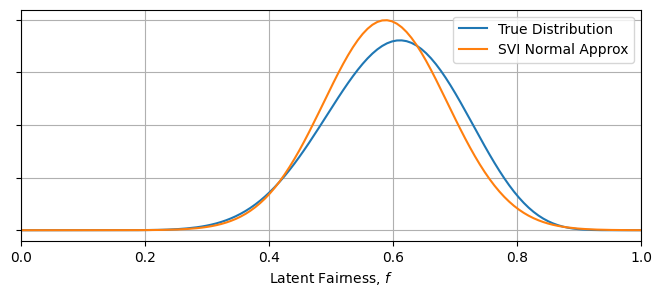

In [8]:
params_norm = svi_result_norm.params

#----------------------------------
print("-"*76)
print("\t Truth \t SVI")
print("Mean \t %0.2f \t %0.2f" %(mean_true, params_norm["mean"]))
print("B \t %0.2f \t %0.2f" %(var_true, params_norm["var"]))
print("-"*76)
#----------------------------------

Xplot = np.linspace(0,1,128)
plt.figure(figsize = (8,3))
plt.plot(Xplot, beta(A_true,B_true).pdf(Xplot), label = "True Distribution")
plt.plot(Xplot, norm(params_norm["mean"],params_norm["var"]).pdf(Xplot), label = "SVI Normal Approx")
plt.xlim(0,1)
plt.gca().yaxis.set_ticklabels([])
plt.xlabel("Latent Fairness, $f$")
plt.grid()
plt.legend()

plt.show()

There is a slight detail that I've smoothed over here: the $\beta$ distribution is technically only defined on the interval $x\in[0,1]$, while the normal distribution is defined over all real numbers. The two distributions have different [supports](https://en.wikipedia.org/wiki/Support_(mathematics)). We can get away with this discrepency in this well behaved case, but mixing and matching dissimilar distributions can lead to badly fit surrogate distributions, and can even break the numerical fitting procedure.

## Acquiring / Interpreting Results from SVI <a id='interpreting'></a>

Once an SVI optimization has run, the most general way to convert the optimal results back into measurement space or parameter space is to use the `infer.Predict` object in NumpPyro. In regards to SVI, we have three paths of interest:
1. [One](#): Feeding a model _and_ optimized guide into a `Predict` object to yield mock observations
2. [Two](#predictive_MCMClike): Feeding _just the guide_ and its optimal tuning gives us samples in parameter space
3. [Three](#): We can feed parameters from (2) and a model to get fake observations

- Todo: Halting Condition / convergence intro

### Getting MCMC-Like Posterior Samples <a id='predictive_MCMClike'></a>

Given MCMC is the go-to tool of most Bayesian statisticians, it's useful to be able to take an SVI result and pull out something like an MCMC chain: an array of independent samples distributed proportional to their posterior probability. Fortunately, NumPyro's `infer.Predict` object does much of the heavy lifting for us in this regard. We can draw out an MCMC-like chain of samples in only one or two lines by the feeding `Predict` a model or guide along with the result of our optimization:

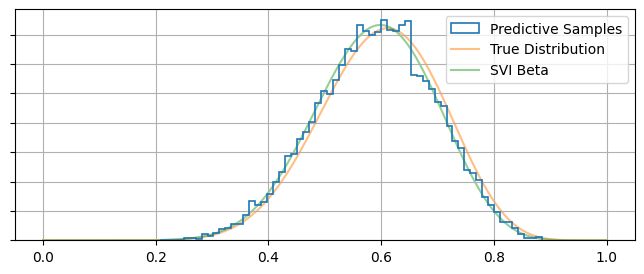

In [9]:
# get posterior samples
predictive_MCMClike = Predictive(guide_beta, params=svi_beta_result.params, num_samples=10000)
posterior_samples = predictive_MCMClike(random.PRNGKey(1), data=None) # Don't supply data here! Conditioning already performed by the optimization

#------------------
# Plotting
plt.figure(figsize = (8,3))

plt.hist(posterior_samples['latent_fairness'], bins = 64, histtype='step', density=True, label = "Predictive Samples", lw = 1.2, zorder = 10)
plt.plot(Xplot, beta(A_true, B_true).pdf(Xplot), label = "True Distribution", zorder = -1, alpha= 0.5)
plt.plot(Xplot, beta(A_beta, B_beta).pdf(Xplot), label = "SVI Beta", zorder = -1, alpha= 0.5)

plt.gca().yaxis.set_ticklabels([])
plt.legend()
plt.grid()

plt.show()

### Mock Observations <a id='mock_observations'></a>
Alternately, we use `Predict` to generate some mock-data according to our surrogate posterior. In the following, we use the optimal surrogate distributions to draw many different weights for the coin, and use these to guide our numpyro model to generate random mock-inputs that would emulate the statistical properties of our input data:

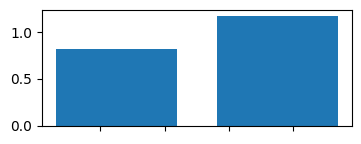

In [10]:
# use guide to make predictive
predictive_fromguide = Predictive(model_headstails, guide=guide_beta, params=svi_beta_result.params, num_samples=1000)
samples_fromguide = predictive_fromguide(random.PRNGKey(1), data=None)

plt.figure(figsize = (4,1.5))
plt.hist(samples_fromguide['obs'].reshape(1000*10),bins=2, rwidth=0.75, density=True)
plt.gca().set_xticklabels([])
plt.show()


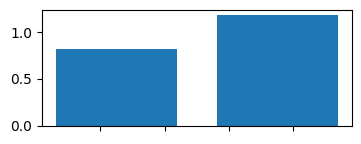

In [11]:
# use posterior samples to make predictive
predictive_fromsamples = Predictive(model_headstails, posterior_samples, params=svi_beta_result.params)
samples_fromsamples = predictive_fromsamples(random.PRNGKey(1), data=None)

plt.figure(figsize = (4,1.5))
plt.hist(samples_fromsamples['obs'].reshape(10000*10),bins=2, rwidth=0.75, density=True)
plt.gca().set_xticklabels([])
plt.show()

### Ensuring Convergence <a id='convergence'></a>
One danger of SVI is that it is at the mercy of the optimiser you tune it with. Unlike MCMC, where we can identify poor convergence by eye, SVI's smooth distributions can give misleading confidence, especially when using an optimizer like `Adam` which doesn't have any self-halting criteria. It's up to the user to choose a size and number of steps for this optimization, and it's important double check that this process has actually converged to an optimal surrogate model. 

A quick and easy way to do this is to check the loss function / ELBO to make sure it has settled out to a plateau value, which we can do by retrieving the losses from the `SVIRunResult` object:

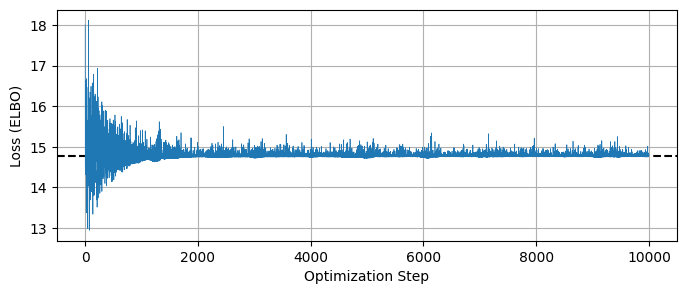

In [12]:
LOSSES = svi_beta_result.losses

plt.figure(figsize = (8,3))
plt.plot(LOSSES, lw=0.5)
plt.axhline(np.median(svi_beta_result.losses[::-100]), c='k', ls='--', zorder = -1)
plt.xlabel("Optimization Step"), plt.ylabel("Loss (ELBO)")
plt.grid()
plt.show()

Similarly, we need to be careful of the usual pitfalls of optimization like multimodality and local optima. You'll also notice that the loss function doesn't quite settle out to a minumum, and jumps around a bit. This variance is an unavoidable feature of the stochastic nature of the ELBO evaluation, but we can get a smoother result if we change the `num_particles` argument in the `Trace_ELBO` loss function calculator when doing SVI. For example, re-running our beta distribution fit, but this time using `num_particles = 32` instead of the default value of 1:

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2879.38it/s, init loss: 15.1206, avg. loss [9501-10000]: 14.7885]


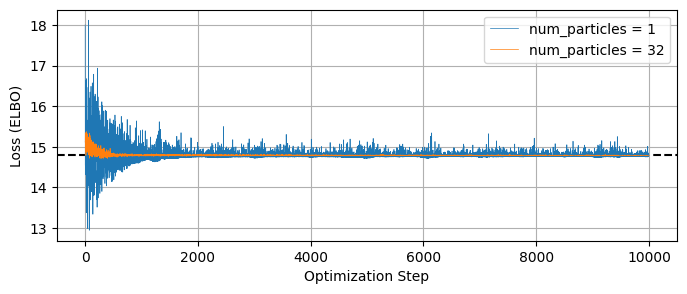

In [13]:
# Make and run the SVI object with more ELBO particles
svi_beta = SVI(model_headstails, guide_beta, optimizer, loss=Trace_ELBO(num_particles = 32))
svi_beta_result = svi_beta.run(random.PRNGKey(1), num_steps = 10000, data = data_headstails)

plt.figure(figsize = (8,3))
plt.plot(LOSSES, lw=0.5, label = 'num_particles = 1')
plt.plot(svi_beta_result.losses, lw=0.5, label = 'num_particles = 32')
plt.legend()
plt.axhline(np.median(svi_beta_result.losses[::-100]), c='k', ls='--', zorder = -1)
plt.xlabel("Optimization Step"), plt.ylabel("Loss (ELBO)")
plt.grid()
plt.show()

The gradient of this ELBO estimate is what guides the SVI optimization, and so increasing `num_particles` should may improved performance if you're having issues with convergence.

## Some Small Examples <a id="small_examples"></a>

### Building a Complicated Models From Mixtures <a id='mixtures'></a>

In the previous example we worked with a simple 1-parameter case, and it's easy to extend that working out to multidimensional cases where our surrogate model has similarly simple and independent distributions for each parameter. Of course, many cases are sadly not like this: how do we construct guides that account for things like reparamaterizaion, correlated variables or multimdal distributions? 

Here, I outline an example of a less-than-simple posterior and a way to construct a guide that can approximate it, and then try to fit a multimodal gaussian mixture model to this distribution using SVI. In real-world use cases, the posterior will come from a model conditioned by some set of data, but in this example I'll take the shortcut of defining an arbitrary posterior with some non-trivial geometry. Specifically, I'm going to use a distribution that is multimodal and gaussian:

$$
q(x,y) =  [e^{-(u_1-b)^2} + e^{-(u_1+b)^2}]\cdot \frac{1}{1+u_2^2}
$$

Where $u_1$ and $u_2$ are principle axis' aligned at 45 degrees:

$$
u_1 = cos(\theta) x - sin(\theta) y, \;\;\; u_2 = cos(\theta) x + sin(\theta) y
$$

First, construct this distribution as a NumPyro model:

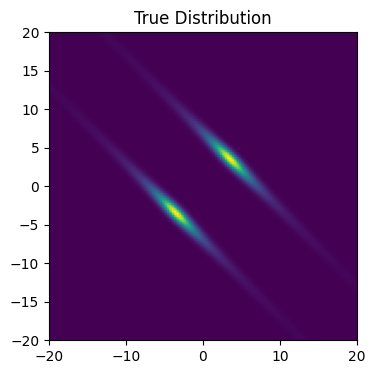

In [14]:
sig1, sig2 , b = 0.5, 2.0, 5.0

def log_distribution(x,y):
    '''
    An arbitrary distribution, multimodal & correlated
    '''
    sqrt2 = 2**0.5
    
    f1 = jnp.exp(-1/2* (((x+y)/sqrt2 - b)/sig1)**2 )
    f2 = jnp.exp(-1/2* (((x+y)/sqrt2 + b)/sig1)**2 )
    
    log_fac = jnp.log(f1+f2) # Multimodal normal distribution along axis 1
    log_fac +=  + jnp.log(1 / (1 + ((x-y)/sig2 / sqrt2)**2 /2 )) # Cauchy dist along axis 2

    return(log_fac)

def model_multimodal():
    '''
    A numpyro model for that reproduces log_distribution
    '''
    x = numpyro.sample('x', numpyro.distributions.Uniform(-20,20))
    y = numpyro.sample('y', numpyro.distributions.Uniform(-20,20))
    
    log_fac = log_distribution(x,y)
        
    numpyro.factor('logfac', log_fac)

#-----------------------------
# Plot
plt.figure(figsize=(4,4))

X, Y = np.meshgrid(np.linspace(-20,20,128),np.linspace(-20,20,128))
Z = np.exp(log_distribution(X,Y))
plt.imshow(Z[::-1], extent = [-20,20,-20,20])
plt.axis('square')
plt.title("True Distribution")
plt.show()


Now we need to construct an SVI guide to describe our surrogate distribution. As always, we need to assume some approximate shape to the distribution, and I'm going to go with two gaussians rotated at angle $\theta$, separated by distance $b$, of equal height and with principle axis variances $\sigma_1$ and $\sigma_2$. To construct this as a guide, we need to use two tricks:
1. Using the `numpyro.distributions.MixtureGeneral` to create the two modes
2. Using a trick with `dist.Delta` to reparameterize the samples back into the latent model variables '$x$' and '$y$'

In [15]:
def guide_multimodal():
    '''Multimodal guide'''

    # Define model parameters
    sig1_q = numpyro.param('sig1_q', 1.0, constraint = constraints.positive) # Principle axis variance 1
    sig2_q = numpyro.param('sig2_q', 1.0, constraint = constraints.positive) # Principle axis variance 2
    b      = numpyro.param('b'     , 1.0, constraint = constraints.positive) # Mode separation

    theta = numpyro.param('theta', 0.0, constraint = constraints.interval(-np.pi/2, np.pi/2)) # Rotation

    #-------------------------------------
    # Gaussian Mixture model along axis u1
    weighting = jnp.array([0.5,0.5])
    gauss_mix = numpyro.distributions.MixtureGeneral(
        dist.Categorical(weighting),
        [
            dist.Normal(loc=b, scale=sig1_q),
            dist.Normal(loc=-b, scale=sig1_q)
        ]
    )
    u1 = numpyro.sample("u1", gauss_mix ,infer={'is_auxiliary': True})

    # Simple gaussian distribution along u2
    u2 = numpyro.sample("u2", dist.Normal(0,sig2_q) ,infer={'is_auxiliary': True})

    #-------------------------------------    
    # Convert to 'x' and 'y' to line up with numpyro model latent site names
    c, s = jnp.cos(theta), jnp.sin(theta)

    x = numpyro.sample('x', dist.Delta(c*u1 - s*u2))
    y = numpyro.sample('y', dist.Delta(c*u2 + s*u1))
    

In the guide, the `dist.Categorical` represents the fact that any given sample has a 50/50 chance of being drawn from one mode or the other, while the list that comes as the second argument of `MixtureGeneral` contains the distributions describing each mode. If you wanted to allow the mode heights to vary, you could add another `param` to tune the weights of the modes, e.g:

```python
    weight = numpyro.param('weight', 0.5, constraint = constraints.unit_interval)
    weighting = jnp.array([weight, 1-weight])
```

In this guide we've used the trick of separating the surrogate distribution out into two factors, $q(x,y)= q_1(u_1) \cdot q_2(u_2)$. We just need to sample $u_1$ and $u_2$ from their respective distributions and convert back into the parameters we actually care about with a deterministic reparameterization: $x=x(u_1,u_2)$ and $y=y(u_1,u_2)$. Strangely, the `numpyro.deterministic` object isn't the right tool for the job here, as NumPyro requires $x$ and $y$ to be `sample` type objects. Intead, we acomplish the same end goal by constraining them with a `delta` distribution, as $x \sim \delta(x')$ is the same as saying $x=x'$.

With our guide set up, we can just run the SVI optimization the same as we would for a 1D model. As always, it's worth plotting the losses to make sure everything has converged properly:

100%|███████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3181.75it/s, init loss: 40.1734, avg. loss [9501-10000]: 4.4520]


Optimal Guide Params
----------------------------------------------------------------------------
b:	4.990
sig1_q:	0.505
sig2_q:	4.676
theta:	44.7 deg
----------------------------------------------------------------------------


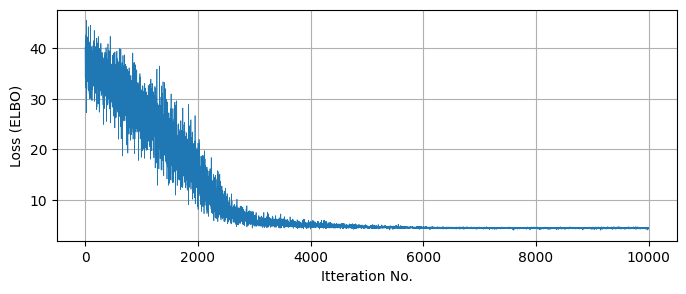

In [16]:
optimizer = numpyro.optim.Adam(step_size=0.0005)
svi_multimodal= SVI(model_multimodal, guide_multimodal, optimizer, loss=Trace_ELBO(num_particles = 16))
svi_multimodal_result = svi_multimodal.run(random.PRNGKey(1), 10000)

print("Optimal Guide Params")
print("-"*76)
for key, val in zip(svi_multimodal_result.params.keys(), svi_multimodal_result.params.values()):
    if key != "theta":
        print("%s:\t%0.3f" %(key,val) )
    else:
        print("%s:\t%0.1f deg" %(key,val*180/np.pi) )
print("-"*76)
#-------------------------
# Plotting
plt.figure(figsize = (8,3))
plt.grid()
plt.plot(svi_multimodal_result.losses, lw=0.5)
plt.xlabel("Itteration No.")
plt.ylabel("Loss (ELBO)")
plt.show()

Plotting the true posterior and some samples drawn from our predictive model, we can see that we've succesfully recovered the broad behaviour with SVI:

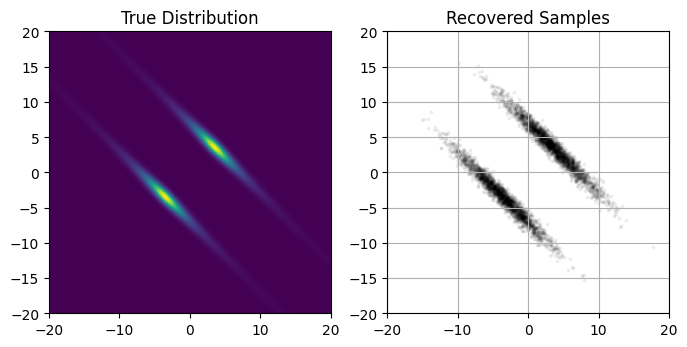

In [17]:
#-----------------------------
# Plot
fig, ax = plt.subplots(1, 2 , figsize = (8,4) )

ax[0].imshow(Z[::-1], extent = [-20,20,-20,20] )
ax[0].axis('square')
ax[0].set_title("True Distribution")

#-----------------------------
# get posterior samples
predictive_MCMClike = Predictive(guide_multimodal, params=svi_multimodal_result.params, num_samples=5000)
posterior_samples = predictive_MCMClike(random.PRNGKey(1))
Xsample, Ysample = posterior_samples['x'], posterior_samples['y']

ax[1].scatter(Xsample,Ysample, s=3, c='k', alpha=0.05)
ax[1].grid()
ax[1].axis('square')
ax[1].set_xlim(-20,20), ax[1].set_ylim(-20,20)
ax[1].set_title("Recovered Samples")

#-----------------------------
plt.show()

### Autoguides: Simpler & Faster <a id='autoguides'></a>
So far we've only looked at guides that we've explicitly constructed ourselves using NumPyro primitives. This approach gives us a lot of control and flexibility, but can get overly tedious if we're working with many parameters. NumPyro presentes an alternative in [autoguides](https://num.pyro.ai/en/latest/_modules/numpyro/infer/autoguide.html), handy utilities that _automatically_ construct guides for a single NumPyro model in a single line of code.

Autoguides are limited in that they only give a small family of guides to fit, namely variations on gaussian distributions (uncorrelated, correlated, the Laplace approximation etc), but have the advantage of being blindingly easy to use and scaling much more easily into high dimensions. In this quick example I'll show how we can use an autoguide to construct a 2D multivariate distribution. I'll start by defining a toy model in NumPyro, specifically a 2D gaussian with $\sigma_1=1, \sigma_2 =3$ and angled at $45\degree$. 

Notice that I've used an _improper_ prior in this model, letting $x$ and $y$ be fully unconstrained. I could have just as easily used vague normal distributions to the same end, but I've opted to use these unbounded uniform distributions for neatness.

In [53]:
sig1, sig2, theta = 1.0, 3.0, 45*np.pi/180 # Variances and angle of gaussian

def factor(x,y):
    # The PDF to feed into NumPyro
    c,s = jnp.cos(theta), jnp.sin(theta)
    log_fac = -1.0 / 2.0 * ( ( (c*x- s*y) / sig1 )**2 + ( (s*x + c*y) / sig2)**2 )
    return(jnp.exp(log_fac))

def model_forauto():
    # NumPyro model using factor()
    x = numpyro.sample('x', numpyro.distributions.ImproperUniform(constraints.real, (), () ) )
    y = numpyro.sample('y', numpyro.distributions.ImproperUniform(constraints.real, (), () ) )

    log_fac = jnp.log(factor(x,y))
    numpyro.factor('logfac', log_fac)

Now, we have numpyro generate a guide for us by feeding the model into an `infer.autofuide.AutoMultivariateNormal` object. In one line, this generates a guide that will fit a multivariate normal distribution, fully parameterized and ready to roll in an SVI optimization:

In [19]:
optimizer_forauto = numpyro.optim.Adam(step_size=0.0005)

autoguide = numpyro.infer.autoguide.AutoMultivariateNormal(model_forauto)

autosvi = SVI(model_forauto, autoguide, optim = optimizer_forauto, loss=Trace_ELBO())
autosvi_result = autosvi.run(random.PRNGKey(2), 50000)

100%|█████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 11756.12it/s, init loss: 3.3177, avg. loss [47501-50000]: -2.9368]


Plotting the output of this autoguide, we see that it's recovered the gaussian distribution without any hiccups:

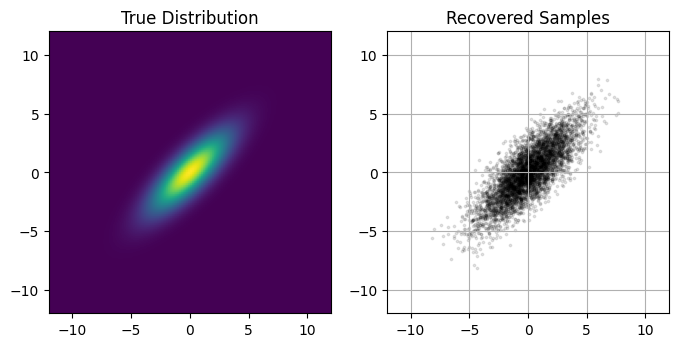

In [20]:
#-----------------------------
# Plot
fig, ax = plt.subplots(1, 2 , figsize = (8,4) )

X, Y = np.meshgrid(np.linspace(exmin,exmax,128),np.linspace(exmin,exmax,128))
Z = factor(X,Y)
ax[0].imshow(Z[::-1], extent = [exmin, exmax, exmin, exmax])
ax[0].axis('square')
ax[0].set_title("True Distribution")

#-----------------------------
# get posterior samples
predictive_MCMClike = Predictive(autoguide, params=autosvi_result.params, num_samples=5000)
posterior_samples = predictive_MCMClike(random.PRNGKey(1))
Xsample, Ysample = posterior_samples['x'], posterior_samples['y']

ax[1].scatter(Xsample,Ysample, s=3, c='k', alpha=0.1)
ax[1].grid()
ax[1].axis('square')
ax[1].set_xlim(exmin,exmax), ax[1].set_ylim(exmin,exmax)
ax[1].set_title("Recovered Samples")

#-----------------------------
plt.show()

**Recovering Covariance Matrix**
We could estimate the mean and covariance matrix of the posterior from these samples alone, but we can also extract them directly from the SVI run. `AutoguideMultivariate` stores its covariance results in the lower triangular [Cholesky Matrix](https://en.wikipedia.org/wiki/Cholesky_decomposition), a sort of "square root" of the covariance matrix:

$$
    C^{-1} = L L^T
$$

We can access this from the SVI results with `.params['auto_scale_tril']`, and use then use this to reconstruct the covariance matrix. For the sake of comparison, we can then determine its principle axis and variances along these axis from the eigenvalues / vectors. 

There's only one hitch: the normal distribution and resulting $L$ matrix are defined in terms of _unconstrained_ parameter space values, and so the $C$ recovered above can be in the wrong coordinate system depending on your priors. This results in a covariance matrix that can be hard to interpret, as the constrained / unconstrained transformations aren't straightforward and change across parameter space. In this example, we've side-stepped this by using the unconstrained improper prior `ImproperUniform`.

In [75]:
# Get Lower Triangluar Cholesky Matrix and recover covariance matrix
L = autosvi_result.params['auto_scale_tril']
COVAR_REC = jnp.dot(L,L.T)

print("Recovered covariance matrix:")
print(COVAR_REC.round(3))

# Get eigenvalues / vectors
sigs, us = jnp.linalg.eig(COVAR_REC)

print("Recovered Variances:")
sig1_rec, sig2_rec  = jnp.real(sigs)**(1.0/2.0)
print("σ1 = %0.2f, σ2 = %0.2f" %(sig1_rec, sig2_rec))

print("Recovered Contour Angle:")
u1, u2 = jnp.real(us)
thet_rec = np.arctan(u1[1] / u1[0])
print("θ = %0.2f°" %(thet_rec * 180/ np.pi))

Recovered covariance matrix:
[[4.918 4.03 ]
 [4.03  5.177]]
Recovered Variances:
σ1 = 1.01, σ2 = 3.01
Recovered Contour Angle:
θ = 44.08°


# A Practical Example: Linear Regression With Outliers <a id='Example_1'></a>

I've kept things in the previous sections to small toy examplesto outline the basics of SVI, but full full worked examples can help paint a clearer picture of how to actually apply it as practical tool. In this section, I use SVI to tackle a linear regression with outliers, the same problem worked through using MCMC-like tools in the first example of Dan Foreman Mackey's excellent [astronomer's introduction to numpyro](https://dfm.io/posts/intro-to-numpyro/).

In this problem, we generate a set of linear observations with gaussian error, and then replace some random sub-set of these measurements with outliers drawn from a static gaussian. Our model then has five parameters: the slope '$m$' and offset '$c$' of the line, the mean '$\mu_{bg}$' and spread '$\sigma_{bg}$' of the outliers, and '$Q$', the fraction of observations that are outliers. We put this all together as a mixture model, saying that any given measurement $y_i$ obeys a linear combination of the "foreground" linear trend and the "background" outlier gaussian:

$$
y_i \sim N(m x_i + c, E_i) \cdot Q + N(\mu_{bg},\sigma_{bg})\cdot(1-Q)
$$

We're looking to constrain each of these five parameters, and I'm going to attack this problem in four ways:
- Via MCMC as DFM does
- By SVI using:
   - A manually constructed guide
   - A diagonal (uncorrelated) gaussian via an autoguide
   - A correlated gaussian autoguide

I've directly replicated the probabalistic modelling from DFM's example, including his choice of using a uniform prior over the slope _angle_ $\theta$ and perpendicular offset $b_{perp}$ instead of the gradient and vertical offset, as well as his settup for MCMC:

In [22]:
from numpyro.distributions import MixtureGeneral
from numpyro import infer

#Extracted directly from DFM example

# Model
def linear_mixture_model(x, yerr, y=None):

    # Angle & offset of linear relationship
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))

    # Linear relationship distribution
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    fg_dist = dist.Normal(m * x + b, yerr)

    # Pure normally distributed background for outliers
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))

    # Mixture of linear foreground / w background
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0)) # Relative weighting of foreground & background
    mix = dist.Categorical(probs=jnp.array([Q, 1.0 - Q])) # Categorical distribution = each sample has a weighted chance of belonging to each category

    # Using mixture distribution, measure likelihood of all observations
    with numpyro.plate("data", len(x)):
        numpyro.sample("obs", MixtureGeneral(mix, [fg_dist, bg_dist]), obs=y)

#--------------------------------------------------------
# Data Generation
true_frac = 0.8 # Fraction of outliers
true_params = [1.0, 0.0] # slope & offset of linrel
true_outliers = [0.0, 1.0] # mean and sigma of background

# Generate data
def gen_data(seed = 12):
    np.random.seed(seed)
    x = np.sort(np.random.uniform(-2, 2, 15))
    yerr = 0.2 * np.ones_like(x)
    y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))
    
    # Shuffle outliers
    m_bkg = np.random.rand(len(x)) > true_frac # select these elements to re-sample from bg dist
    y[m_bkg] = true_outliers[0]
    y[m_bkg] += np.sqrt(true_outliers[1] + yerr[m_bkg] ** 2) * np.random.randn(sum(m_bkg))

    return(x,y,yerr)
x, y, yerr = gen_data(seed=12)

#--------------------------------------------------------
# Run MCMC chain
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_model),
    num_warmup=1000,
    num_samples=20000,
    num_chains=1,
    progress_bar=True,
)
print("Doing MCMC")
%time sampler.run(jax.random.PRNGKey(3), x, yerr, y=y)


Doing MCMC


sample: 100%|█████████████████████████████████████████████████████████████| 21000/21000 [00:06<00:00, 3143.07it/s, 7 steps of size 4.31e-01. acc. prob=0.95]


CPU times: user 7.96 s, sys: 83.2 ms, total: 8.05 s
Wall time: 8.67 s


**Constructing a Guide Manually**  
Now we can get onto attacking this problem with SVI as a comparison. First up, I'll construct a surrogate distribution guide manually, using a simple case where every parameter is independent. Most of the parameters end up being well constrained, and so we can get away with approximating them by normal distributions. The one exception is $Q$, the fraction of outliers. $Q$ is restricted to the domain $Q\in [0,1]$ and is poorly constrained: not only is a gaussian a bad match in terms of "shape", it can also easily break the entire SVI optimization machine. One option would be to instead use a normal distribution that had been transformed into the constrained domain, restricting to $Q \in [0,1]$, e.g.:

'''python
    Q_mu  = numpyro.param('Q_mu',  0.5, constraint =constraints.real)
    Q_sig = numpyro.param('Q_sig', 0.1, constraint =constraints.positive)

    transformed_dist = dist.TransformedDistribution(
                dist.Normal(Q_mu, Q_sig),
                dist.transforms.UnitInterval(),
            )
    
    Q = numpyro.sample('Q', transformed_dist)
'''

But I've instead gone for the much simpler option of using a beta distribution instead. This is a motivated choice: not only do beta distributions already have the current "support" (domain) but it is also a natural fit for estimating the "weighting" of a binary choice, which $Q$ represents:

In [23]:
def manual_guide(x, yerr, y):

    #------------------------------
    # Distribution Means
    
    bg_mean_mu  = numpyro.param('bg_mean_mu',  0.0, constraint =constraints.real)
    bg_sigma_mu = numpyro.param('bg_sigma_mu', 0.5, constraint =constraints.positive)
    theta_mu    = numpyro.param('theta_mu',    0.0, constraint =constraints.interval(-jnp.pi/2, jnp.pi/2))
    b_perp_mu   = numpyro.param('bg_perp_mu',  0.0, constraint =constraints.real)
    
    #------------------------------
    # Distribution Variances
    bg_mean_sigma   = numpyro.param('bg_mean_sigma',  1.0, constraint =constraints.positive)
    bg_sigma_sigma  = numpyro.param('bg_sigma_sigma', 0.2, constraint =constraints.less_than(bg_sigma_mu/2))
    theta_sigma     = numpyro.param('theta_sigma',    0.1, constraint =constraints.positive)
    b_perp_sigma    = numpyro.param('bg_perp_sigma',  0.1, constraint =constraints.positive)

    #------------------------------
    # Q performs poorly with an unconstrained distribution, so use a beta distribution instead
    Q_A = numpyro.param('Q_A', 2, constraint =constraints.positive)
    Q_B = numpyro.param('Q_B', 2, constraint =constraints.positive)
    
    # Construct & Sample Distributions
    numpyro.sample('bg_mean', dist.Normal(bg_mean_mu, bg_mean_sigma))
    numpyro.sample('bg_sigma', dist.Normal( bg_sigma_mu, bg_sigma_sigma ))
    numpyro.sample('theta', dist.Normal(theta_mu, theta_sigma))
    numpyro.sample('Q', dist.Beta(Q_A, Q_B))
    numpyro.sample('b_perp', dist.Normal(b_perp_mu, b_perp_sigma))


We can also create automatic guides with uncorrelated (`AutoDiagonalNormal`) and correlated (`AutoMultivariateNormal`) gaussian distributions and run those for comparison. Firing these off, we find that their physical running times are betteer than MCMC by a factor of 2-3, even in a cheap case where fixed costs like compilation are a major factor, and we could achieve even better times if we were to fiddle with the number of particles or optimizer tuning parameters.

In [24]:
optimizer_forauto = numpyro.optim.Adam(step_size=0.001)
svi_samples = 10000

guide_linreg_diag = numpyro.infer.autoguide.AutoMultivariateNormal(linear_mixture_model)
svi_linreg_diag = SVI(linear_mixture_model, guide_linreg_diag, optim = optimizer_forauto, loss=Trace_ELBO(num_particles=8))
%time result_linreg_diag = svi_linreg_diag.run(random.PRNGKey(1), svi_samples, x, yerr, y=y)

guide_linreg_multi = numpyro.infer.autoguide.AutoDiagonalNormal(linear_mixture_model)
svi_linreg_multi = SVI(linear_mixture_model, guide_linreg_multi, optim = optimizer_forauto, loss=Trace_ELBO(num_particles=8))
%time result_linreg_multi = svi_linreg_multi.run(random.PRNGKey(1), svi_samples, x, yerr, y=y)

svi_linreg_manual = SVI(linear_mixture_model, manual_guide, optim = optimizer_forauto, loss=Trace_ELBO(num_particles=8))
%time result_linreg_manual = svi_linreg_manual.run(random.PRNGKey(1), svi_samples, x, yerr, y=y)

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3594.92it/s, init loss: 47.1368, avg. loss [9501-10000]: 19.8551]


CPU times: user 4.13 s, sys: 179 ms, total: 4.31 s
Wall time: 4.52 s


100%|██████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4720.04it/s, init loss: 47.1368, avg. loss [9501-10000]: 19.9921]


CPU times: user 2.81 s, sys: 19.9 ms, total: 2.83 s
Wall time: 3.04 s


100%|██████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1949.37it/s, init loss: 59.7463, avg. loss [9501-10000]: 20.1456]


CPU times: user 5.91 s, sys: 74.6 ms, total: 5.99 s
Wall time: 6.39 s


The resulting distributions are relatively uncorrelated in the problem we're working with, and so all three guides meander down to similar 'goodness of fit', though taking different times. Note again that the $10,000$ samples is overly conservative, even without tuning of the optimizer. One core advantage of SVI is that it can, in some cases, draw in close to a good for _much_ faster than an exhuastive MCMC run: 

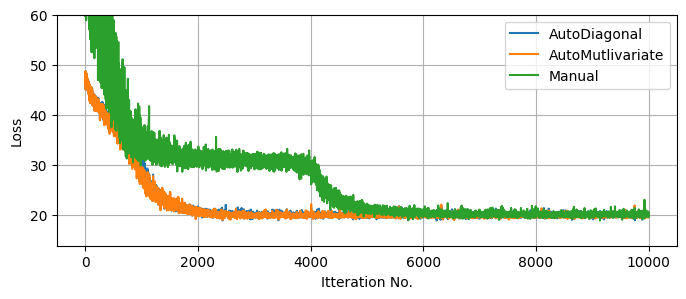

In [25]:
plt.figure(figsize = (8,3))

plt.plot(result_linreg_multi.losses, label = "AutoDiagonal")
plt.plot(result_linreg_diag.losses, label = "AutoMutlivariate")
plt.plot(result_linreg_manual.losses, label = "Manual")

plt.ylabel("Loss")
plt.xlabel("Itteration No.")
plt.ylim(ymax=60)
plt.grid()
plt.legend()
plt.show()

Knowing that our SVI runs are fully converged, we can use them to generate as many samples as we want from the (approximate) posterior. For fairness of comparison, I've kept the number of samples the same as the MCMC run. We can see that, despite the much lower runtime, all three SVI runs do a decent job of matching with the (mostly true) MCMC results, though in places under-representing the non-gaussian tails. 

Notice that the autoguides go a good job of capturing the asymmetry of $Q$ _despite_ being 'normal' distributions. This is because autoguides fit normal distributions in the _unconstrained_ domain, which are then "squished" back into the $Q\in[0,1]$ domain. This distortion allows normal autoguides to be more flexible than they might first appear, though not infinitely so as we see in example 2. By contrast, the manual guide has no distortion at all, the source of its failure to capture the assymetry in $bg_\sigma$.

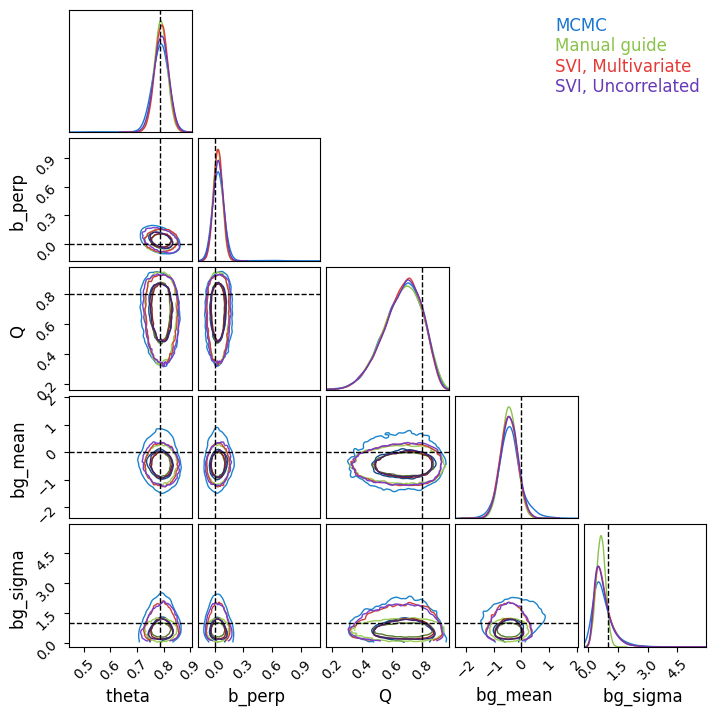

In [26]:
res = sampler.get_samples()

c = ChainConsumer()
c.add_chain(res, name="MCMC")

svi_pred_diag = Predictive(guide_linreg_diag, params = result_linreg_diag.params, num_samples = 20000*2)(rng_key = jax.random.PRNGKey(1))
svi_pred_diag.pop('_auto_latent')

svi_pred_multi = Predictive(guide_linreg_multi, params = result_linreg_multi.params, num_samples = 20000*2)(rng_key = jax.random.PRNGKey(1))
svi_pred_multi.pop('_auto_latent')

svi_pred_manual = Predictive(manual_guide, params = result_linreg_manual.params, num_samples = 20000*2)(rng_key = jax.random.PRNGKey(1), x=x ,y=y, yerr=yerr)

c.add_chain(svi_pred_manual, name="Manual guide")
c.add_chain(svi_pred_multi, name="SVI, Multivariate")
c.add_chain(svi_pred_diag, name="SVI, Uncorrelated")
c.plotter.plot(parameters = ['theta', 'b_perp', 'Q', 'bg_mean', 'bg_sigma'], 
               truth = {'theta':jnp.pi/4, 'b_perp':0, 'Q':0.8, 'bg_mean':0, 'bg_sigma':1})

plt.show()

**Pre-Training SVI**

A major difference between MCMC and SVI is that MCMC contains both an optimization burn-in phase _and_ an exploratory sampling phase, while SVI consists of optimization _only_. If we have some foreknowledge of the distribution, we can initiate our MCMC chains at or near the high likelihood solution to cut down the burn-in time, but the impact of this cleverness is limited by the fact that we will always need a long expensive sampling phase irrespective of how we kick things off. By contrast, SVI is almost all optimization

For example suppose we're handed a second set of data with similar statistical properties to above, and we want to map the posterior distribution for this new data. Using MCMC, we'd need to _at least_ repeat the $\approx 20,000$ samples, making it about as costly at the first MCMC run. Using SVI instead, we can start at our previous optimal solution and adjust to the new data in a fraction of the time, were we're then free to draw as many samples as we want at near zero cost:

100%|██████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1882.15it/s, init loss: 18.1025, avg. loss [9501-10000]: 13.7206]


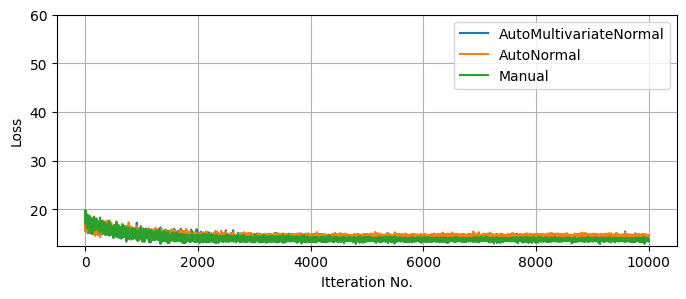

In [27]:
# Generate some new data
xnew, ynew, yerrnew = gen_data(123)

# Run new SVI optimization using old solution as starting point
result_linreg_diag_new = svi_linreg_diag.run(random.PRNGKey(1), svi_samples, xnew, yerrnew, y=ynew, init_params = result_linreg_diag.params)
result_linreg_multi_new = svi_linreg_multi.run(random.PRNGKey(1), svi_samples, xnew, yerrnew, y=ynew, init_params = result_linreg_multi.params)
result_linreg_manual_new = svi_linreg_manual.run(random.PRNGKey(1), svi_samples, xnew, yerrnew, y=ynew, init_params=result_linreg_manual.params)

#-------------------------
# Plot SVI convergence
plt.figure(figsize = (8,3))

plt.plot(result_linreg_diag_new.losses, label = "AutoMultivariateNormal")
plt.plot(result_linreg_multi_new.losses, label = "AutoNormal")
plt.plot(result_linreg_manual_new.losses, label = "Manual")

plt.ylabel("Loss")
plt.xlabel("Itteration No.")
plt.ylim(ymax=60)
plt.grid()
plt.legend()
plt.show()

### Another Practical Example: SVI Vs MCMC In Higher Dimensions For Hierarchial models <a id='Example_2'></a>
In the previous example, we see that SVI competes with or outperforms MCMC in low dimensions ($D<10$), but how does this scale as we climb into the dozens or hundreds of parameters?

As an example, let's consider a _hierarchical_ model of linear regressions, where the measurements of series '$j$' follow a simple linear relationship with linear uncertainty:

$$
    y^j_i \sim N(m^j x_i^j + c^j, E^j_i)
$$

But the gradient '$m^j$' and offset '$c^j$' of each group follow population-wide distributions of unknown mean and variance:

$$
m^j \sim N(\mu_m,\sigma_m), \;\;\; c^j \sim N(\mu_c,\sigma_c) 
$$

If we have $J$ groups, two paramaters per group gives us $D=2J+4$ dimensions, allowing the dimensionality of the problem to easily climb into the dozens in realistic cases.

In [28]:
# Data Generation
N_data = 8
xmin, xmax = -10, 10 # Range of X values for data sampling
ebar, escatter = 2.5, 1000 # Average & spread of error bar

lenmin, lenmax = 6, 18

# Gradient & Offset of each line is normally distributed
m_mu, m_sig, c_mu, c_sig = 0.5, 0.2, 10.0, 1.0 
truth = {"m_mu":m_mu, "m_sig":m_sig,"c_mu":c_mu, "c_sig":c_sig}

#-----------------------
# Generate Data
np.random.seed(1)

lens = lenmin + dist.Binomial(lenmax-lenmin,0.5).sample(jax.random.PRNGKey(1), sample_shape=(N_data,)) # Number of samples for each line
DATA = []
Mtrue, Ctrue = [], [] 
for i in range(N_data):
    n = lens[i]

    # Generate X values
    X = np.random.rand(n) * (xmax-xmin) + xmin
    X.sort()

    # Generate slope & Offset for line
    m, c = np.random.randn()*m_sig + m_mu, np.random.randn()*c_sig + c_mu
    Mtrue.append(m), Ctrue.append(c)

    # Generate Errorbars & Y values
    E = (np.random.poisson(lam=escatter, size=len(X)) / escatter + 1)/2 * ebar
    Y = m*X + c + E * np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'

    # Append to output
    DATA.append({"X":X,
                "Y":Y,
                "E":E})

I        = jnp.concatenate([jnp.array([i]*len(a['X'])) for a,i in zip(DATA,range(len(DATA)))])
X_concat = jnp.concatenate([a['X'] for a in DATA])
Y_concat = jnp.concatenate([a['Y'] for a in DATA])
E_concat = jnp.concatenate([a['E'] for a in DATA])

DATA_concat = ({"I":I,
                "X":X_concat,
                "Y":Y_concat,
                "E":E_concat})

In a practical context, the motivation is that any _one_ source may have insufficient data to constrain $m$ and $c$, but we can leverage their distributions across the entire population to get better constraints. In effect, we're tuning our population-level priors at the same time as we apply them. In this example, we'll uses $J=8$ groups with $I\approx12$ measurements per group. Each group has (with $1\sigma$ uncertainty) a gradient $m=0.5 \pm 0.2$ and offset $c=10 \pm 1$.

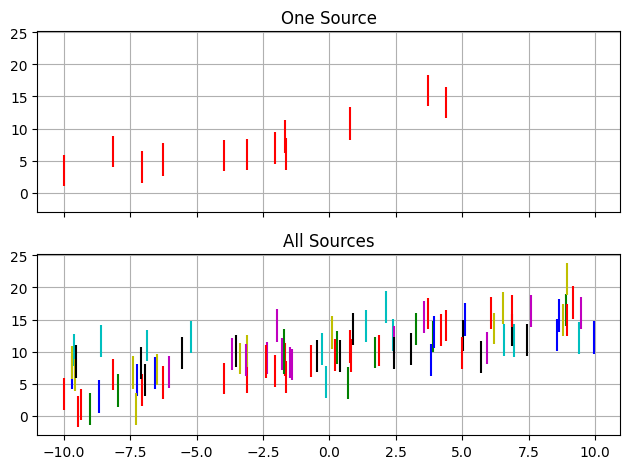

In [29]:
#---------------------
# Plotting

fig, ax = plt.subplots(2,1, sharex=True, sharey=True)

i=0
colors = 'rgbcymk'
colors*=max(1,N_data//len(colors)+1)
colors = list(colors)

ax[0].errorbar(DATA[0]['X'], DATA[0]['Y'], DATA[0]['E'], fmt="none", c = colors[i], label = i)
for data in DATA:
    X,Y,E = data['X'], data['Y'], data['E']
    ax[1].errorbar(X, Y, E, fmt="none", c = colors[i], label = i)
    i+=1

#--------------------------------------------------------

ax[0].grid()
ax[1].grid()
ax[0].set_title("One Source")
ax[1].set_title("All Sources")

#--------------------------------------------------------
plt.tight_layout()
plt.show()

**Define Hierarchical NumPyro Model**  
First, we need to actually define a NumPyro model than can do this hierarchical linear regression. Hierarchical models like this compose easily: the population-level distributions act a bit like priors on each source:

$$
\mathcal{L}(\{ m^j,c^j \},\mu_m, \sigma_m, \mu_c, \sigma_c \vert {\{y\}_i^j}) \propto \prod_j \left(  \prod_i  N(m^j x_i^j + c^j, E^j_i)
\right) \cdot N(m_j-\mu_m,\sigma_m)\cdot N(c_j-\mu_c,\sigma_c) 
$$

Where this likelihood is modulated by extremely vague "hyper-priors" on the population distributions. As $m$ and $c$ can be positive or negative, their mean values can be positive or negative:

$$
\mu_m \sim N(0,15), \;\; \mu_c \sim N(0,25)
$$
But their variability must be resticted to positive values, so I've defined these with wide "half-normal" distributions.
$$
\sigma_m \sim N^+(15), \;\; \sigma_c \sim N^+(25)
$$

Strictly the "correct" way to do this is to use a plate that runs over every group encapsulating each individual linear regression, but I've instead followed the [NumPyro Example](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html) for a similar problem. This has the unusual (but computationally efficient) settup of defining _arrays_ of gradients and offsets as a single object:

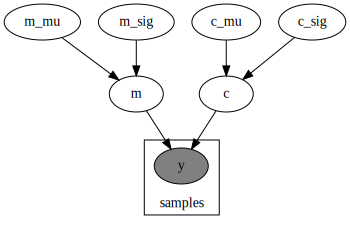

In [30]:
def model_hierarchy(I, X, Y=None, E=None):
    no_sources = len(np.unique(I))

    # Vague Hyperpriors
    m_mu  = numpyro.sample('m_mu',  dist.Normal(0.0, 15.0))
    m_sig = numpyro.sample('m_sig', dist.HalfNormal(10.0))
    c_mu  = numpyro.sample('c_mu',  dist.Normal(0.0, 25.0))
    c_sig = numpyro.sample('c_sig', dist.HalfNormal(15.0))
    

    # Sample grads & offsets for entire population
    m = numpyro.sample('m', dist.Normal(m_mu, m_sig), sample_shape = (no_sources,) )
    c = numpyro.sample('c', dist.Normal(c_mu, c_sig), sample_shape = (no_sources,) )
    pred = m[I]*X+c[I]

    # Use to sample all obervations
    with numpyro.plate('samples', size = len(X) ):
        numpyro.sample('y', dist.Normal(pred, E), obs = Y)

numpyro.render_model( model_hierarchy, model_args = ( I, X_concat, Y_concat, E_concat, ))

Now we can set about running the MCMC and SVI. Later in this example, it's going to become relevant to compare the convergent states of a few different SVI approaches, and I've increased `num_particles` to an absurdly impractical value of $100$, so that we can better compare their "best fit". Because this over-tuning of the samplers throws out the running time, I'm only going to compare the methods in terms of the _number_ of evaluations, a better test of the real-world applications where each sample is costly.

In [49]:
num_warmup = 2000
num_samples = 20000
num_chains = 1

num_particles = 100
svi_samples = 5000
learning_rate = 0.01

#-----------------------------------
# MCMC
MCMC_hierarchy = numpyro.infer.MCMC(numpyro.infer.NUTS(model_hierarchy), 
                                    num_chains = num_chains, num_samples=num_samples, num_warmup = num_warmup, progress_bar = True)

print("Doing MCMC Warmup")
%time MCMC_hierarchy.warmup(jax.random.PRNGKey(1), I, X_concat, Y_concat, E_concat, extra_fields=("potential_energy",), collect_warmup=True)
MCMC_energies_warmup = MCMC_hierarchy.get_extra_fields()["potential_energy"]

print("Doing MCMC Sampling")
%time MCMC_hierarchy.run(jax.random.PRNGKey(1), I, X_concat, Y_concat, E_concat, extra_fields=("potential_energy",))

#-----------------------------------
# SVI
optimizer_hierarchy = numpyro.optim.Adam(step_size=learning_rate)
print("Doing Diagonal SVI")
autoguide_diag = numpyro.infer.autoguide.AutoDiagonalNormal(model_hierarchy)
SVI_diagonal = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_diag,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_diagonal_results = SVI_diagonal.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)

print("Doing Multivariate SVI")
autoguide_multi = numpyro.infer.autoguide.AutoMultivariateNormal(model_hierarchy)
SVI_multivariate = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_multi,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_multivariate_results = SVI_multivariate.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)

Doing MCMC Warmup


warmup: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 824.36it/s, 15 steps of size 2.70e-01. acc. prob=0.79]


CPU times: user 2.36 s, sys: 63.3 ms, total: 2.42 s
Wall time: 2.59 s
Doing MCMC Sampling


sample: 100%|████████████████████████████████████████████████████████████| 20000/20000 [00:09<00:00, 2100.01it/s, 15 steps of size 2.70e-01. acc. prob=0.88]


CPU times: user 8.75 s, sys: 167 ms, total: 8.92 s
Wall time: 9.61 s
Doing Diagonal SVI


100%|███████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 978.46it/s, init loss: 1566.4958, avg. loss [4751-5000]: 238.6858]


CPU times: user 5.32 s, sys: 2.83 s, total: 8.14 s
Wall time: 5.53 s
Doing Multivariate SVI


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1136.21it/s, init loss: 1566.4958, avg. loss [4751-5000]: 237.8878]


CPU times: user 7.87 s, sys: 15.6 s, total: 23.5 s
Wall time: 4.88 s


Per usual, plot the losses to ensure everything has meaningfully converged. Keep in mind that higher dimensions means more chances for getting pinned in local optima, and so this isn't the _only_ test of convergence, but it still gives us a good view at the optimization speed. As a rough comparison, I've also plotted the 'potential energy' of the MCMC chain, _including_ the burn-in phase. This isn't a perfect one to one comparison, but still helps visualize the comparative timescales of the methods.

The first thing we notice is that, like with a lower dimensional example, SVI converges _extremely_ fast in terms of itterations, and performs decently well in terms of run time even with my absurd particle count. Unsurpringly, the more expressive `AutoguideMultivariateNormal` settles out to a slightly better fit / lower ELBO, but both methods are well and truly converged at only a few thousand samples, while MCMC still has an order of magnitude more evaluations left to go in its sampling phase.

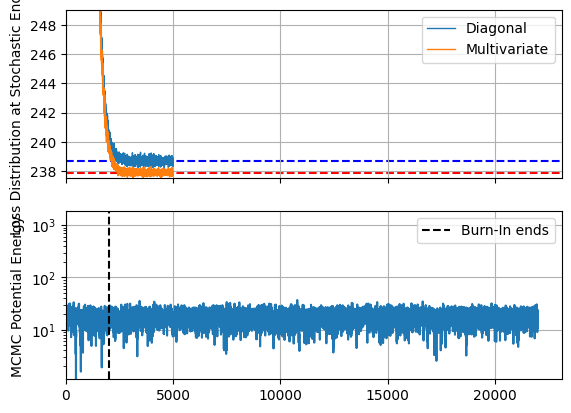

In [50]:
fig, ax = plt.subplots(2,1, sharex=True)

#--------------------------
# SVI plots
ax[0].plot(SVI_diagonal_results.losses, lw=1, label = "Diagonal")
ax[0].plot(SVI_multivariate_results.losses, lw=1, label = "Multivariate")

ax[0].axhline(SVI_diagonal_results.losses[-svi_samples // 10:].mean(), c='b', ls='--', zorder = -2)
ax[0].axhline(SVI_multivariate_results.losses[-svi_samples // 10:].mean(), c='r', ls='--', zorder = -2)

ax[0].set_ylim(ymax=np.min(SVI_multivariate_results.losses)+ np.median(SVI_multivariate_results.losses-np.min(SVI_multivariate_results.losses))*20, ymin=np.min(SVI_multivariate_results.losses))
ax[0].set_ylabel("Loss Distribution at Stochastic End State")

ax[0].grid()
ax[0].legend()

#--------------------------
# MCMC plots
MCMC_energies = np.concatenate([MCMC_energies_warmup, MCMC_hierarchy.get_extra_fields()["potential_energy"]])

ax[1].plot(MCMC_energies - MCMC_energies.min())
ax[1].axvline(num_warmup, c='k', ls='--', label = "Burn-In ends")

ax[1].set_yscale('log')
ax[1].set_ylabel("MCMC Potential Energy")
ax[1].set_xlim(xmin=0)

ax[1].grid()
ax[1].legend()
#--------------------------

plt.show()

Becaus this model has dozens of samples, I'll restrict my corner plot to only the population-wide hierarchical values. Like before, SVI's gaussian assumption under-samples the long tails of the distribution, but broadly does a good job of emulating the underlying posterior. There is one marked caveat to this: the contours for the spread in linear offsets, $\sigma_c$. This distribution is _highly_ non-gaussian, not only in its assymetry but also in its limiting behaviour at $\lim_{\sigma_c \rightarrow 0}$. The autoguides are using a reparameterization trick to "squash" their gaussians into the postive domain, but this still means that they need $\lim_{\sigma_c \rightarrow 0} P(\sigma_c)=0$, while the _actual_ distribution (as recovered by MCMC) presses up against that boundary due to the poor constraints on this parameter.

Pulling results for...
	 m_mu
	 m_sig
	 c_mu
	 c_sig


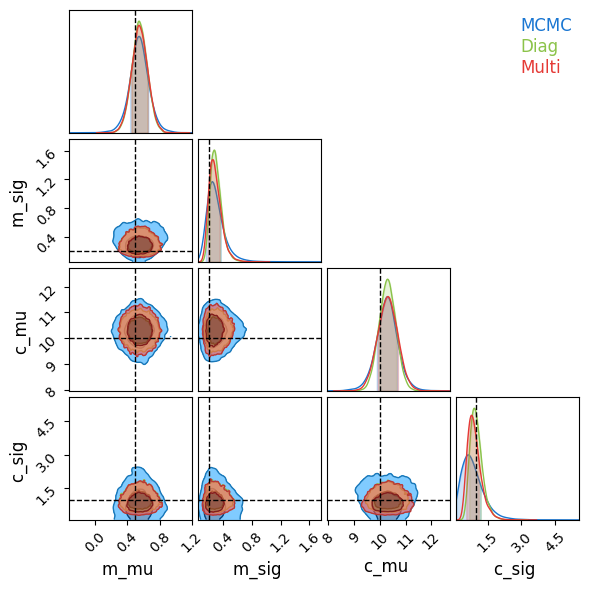

In [51]:
# Acquire Samples
MCMCsamples = MCMC_hierarchy.get_samples()
diagpred = numpyro.infer.Predictive(autoguide_diag, params = SVI_diagonal_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
multipred = numpyro.infer.Predictive(autoguide_multi, params = SVI_multivariate_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)

#------------------------------------------
# Extract to Chain Consumer friendly dictionary
mcmc_res = {}
diag_res = {}
multi_res = {}
print("Pulling results for...")
for key in ['m_mu', 'm_sig', 'c_mu', 'c_sig', ]:
    print("\t",key)
    mcmc_res |= {key: MCMCsamples[key]}
    diag_res |= {key: diagpred[key]}
    multi_res|= {key: multipred[key]}

#------------------------------------------
# Plot in ChainConsumer

C_hierarchy = ChainConsumer()

C_hierarchy.add_chain(mcmc_res, name="MCMC")
C_hierarchy.add_chain(diag_res, name="Diag")
C_hierarchy.add_chain(multi_res, name="Multi")

C_hierarchy.plotter.plot(truth=truth)
plt.show()


It's worth noting that this poor recovery on $P(\sigma_c)$ isn't the end of the world, as it's only a measure of the width of a prior. Plotting a summary of the slopes and offsets recovered for each source, SVI is only very slightly over-constrained as compared to MCMC / truth:

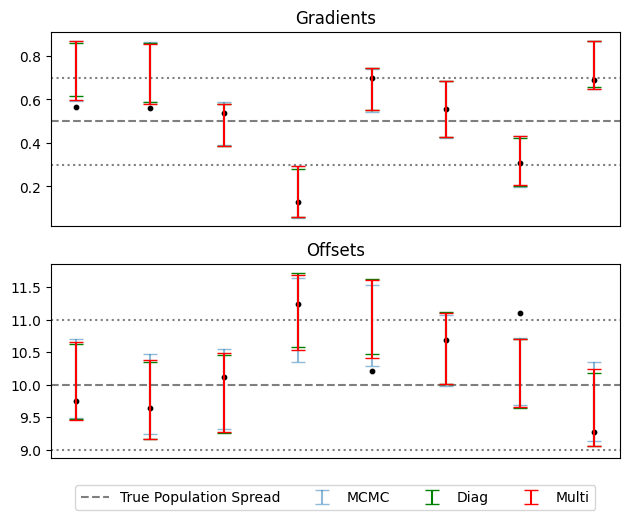

In [52]:
# Acquire SVI samples
A = numpyro.infer.Predictive(autoguide_diag, params = SVI_diagonal_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
B = numpyro.infer.Predictive(autoguide_multi, params = SVI_multivariate_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)

# Plotting recovered means / variances
fig, axis = plt.subplots(2,1, sharex = True)
for i, key in enumerate(['m','c']):
    axis[i].errorbar(range(N_data), MCMC_hierarchy.get_samples()[key].mean(axis=0), MCMC_hierarchy.get_samples()[key].std(axis=0), fmt='none', capsize=5, alpha=.5, label = "MCMC")
    
    axis[i].errorbar(range(N_data), A[key].mean(axis=0), A[key].std(axis=0), fmt='none', capsize=5, c='g', label = "Diag")
    axis[i].errorbar(range(N_data), B[key].mean(axis=0), B[key].std(axis=0), fmt='none', capsize=5, c='r', label = "Multi")

    axis[i].axhline(truth[key+"_mu"], c='k', ls="--", alpha=0.5, zorder=-10, label = "True Population Spread")
    axis[i].axhline(truth[key+"_mu"] + truth[key+"_sig"], c='k', ls=":", alpha=0.5, zorder=-10)
    axis[i].axhline(truth[key+"_mu"] - truth[key+"_sig"], c='k', ls=":", alpha=0.5, zorder=-10)

# Plot True values
axis[0].scatter(range(N_data), Mtrue, c='k', s=10, label = "True")
axis[1].scatter(range(N_data), Ctrue, c='k', s=10)

#--------------------------
axis[0].set_xticks([])
axis[0].set_title("Gradients")
axis[1].set_title("Offsets")
#--------------------------
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

### Non-Gaussian Autoguides <a id='Example_2_non_gaussian'></a>

So far, we've found that SVI is a good alternative to MCMC in fitting our hierarchical model, needing only a fraction of the evaluations to emulate the posterior. However, SVI has fallen short in capturing non-gaussian behaviour of the posterior, specifically in the highly assymetric and non-gaussian distribution for $\sigma_c$. Fortunately, all is not lost: a quick look at NumPyro's [SVI autoguide documentaion](https://num.pyro.ai/en/latest/autoguide.html) reveals that, while `AutoDiagonalNormal` and `AutoMutlivariateNormal` are the _first_ tools we might reach for, they are for from the most powerful. Here, we'll take a swing at fitting our hierarchical model using some other _non_-gaussian methods that NumPyro has to offer, namely:

**DAIS (Differential Annealed Importance Sampling)**  
"_Simulated Annealing_" is a stochastic optimization method in which which a walker navigates around around the likleihood landscape $P(z)$, prefferentially moving up-hill, but with some chance to accept a jump to a "worse" position. The walker starts at a "high" temperature where it readily accepts "downhill" steps, but progresses through 'k' stages of "cooling" where becoming more dedicated to optimization instead of exploration. "_Annealed Importance Sampling_" is a variation on simulated annealing that re-weights the samples from these exploratory chains to get a more an MCMC-like output. Instead of changing the particle "temperature", the cooling process can be described as the probability landscape transitioning from a smooth, easy to navigate function (e.g. the prior) into the final objective function, i.e.:

$$
P_k(z) \propto \pi(z)^{\beta_k}\cdot \left(\pi(z) \mathcal{L}(z) \right)^{1-\beta_k}, \;\; \beta_{k+1}>\beta_k, \;\; \beta_k\in[0,1]
$$

While "_Differential Annealed Importance Sampling_" is a variation that uses HMC-like steps in the random movement of the chain so that we can leverage autograd. The trick for using this in conjunction with SVI is that, rather than starting with the _prior_ as our smooth and easy-to-navigate function, we can use instead use a surrogate model from SVI, e.g. a gaussian. 

$$
P_k(z) \propto q_\phi(z)^{\beta_k}\cdot \left(\pi(z) \mathcal{L}(z) \right)^{1-\beta_k}, \;\; \beta_{k+1}>\beta_k, \;\; \beta_k\in[0,1]
$$

The idea here is that we can get an _approximate_ version of the posterior via standard SVI, and then allow this to diffuse into a non-gaussian shape though the annealing process. NumPyro parameterizes the cooling scale, ${\beta_k}$, as SVI tuning parameters and attempts to optimize over them along with the initial distribution's $\phi$.

**BNAF (Block Nueral Autoregressive Flow)**  & **IAF (Inverse Autoregressive Flows)**  
Normalizing flows are a category of coordinate transformation for probabalistic distributions in which we transform a simple (e.g. gaussian) distribution through some re-parameterization that matches a more complicated posterior. We can perform this transformation using neural networks, parameterizing an optimizing by the weights and offsets in this network to perform SVI just as we would for a more explicit guide. Different implementations of these normalizing flows rely on different neural architecture, all usually relying on some form that gives an easy to calculate determinant, e.g. by having the neural layers be lower triangular. The specifics of how these work isn't too important here, but we should keep in mind that neural networks like this are _highly parameterized_ and _highly expressive_.

In [35]:
# SVI
print("Doing AutoDAIS SVI")

autoguide_dais = numpyro.infer.autoguide.AutoDAIS(model_hierarchy, K=16, eta_max = 0.12, eta_init = 0.1, gamma_init=0.9)
SVI_dais = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_dais,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_dais_results = SVI_dais.run(jax.random.PRNGKey(1), svi_samples * 10, I, X_concat, Y_concat, E_concat)
print("-"*76)

# BNAF
print("Doing BNAF SVI")
autoguide_bnaf = numpyro.infer.autoguide.AutoBNAFNormal(model_hierarchy)
SVI_bnaf = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_bnaf,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_bnaf_results = SVI_bnaf.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)
print("-"*76)

# IAF
print("Doing IAF SVI")
autoguide_iaf = numpyro.infer.autoguide.AutoIAFNormal(model_hierarchy)
SVI_iaf = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_iaf,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_iaf_results = SVI_iaf.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)
print("-"*76)

Doing AutoDAIS SVI


100%|███████████████████████████████████████████████████████| 50000/50000 [03:54<00:00, 213.30it/s, init loss: 1030.5693, avg. loss [47501-50000]: 238.3802]


CPU times: user 3min 47s, sys: 1min 29s, total: 5min 17s
Wall time: 3min 59s
----------------------------------------------------------------------------
Doing BNAF SVI


100%|███████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 319.00it/s, init loss: 1180.0085, avg. loss [4751-5000]: 237.4999]


CPU times: user 22 s, sys: 3.86 s, total: 25.9 s
Wall time: 24.8 s
----------------------------------------------------------------------------
Doing IAF SVI


100%|███████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 700.97it/s, init loss: 1611.8170, avg. loss [4751-5000]: 237.5567]


CPU times: user 7.92 s, sys: 1.73 s, total: 9.66 s
Wall time: 8.59 s
----------------------------------------------------------------------------


After optimizing, we can see that these less traditional SVI guides have managed to capture the non-gaussianity of $\sigma_c$ quite well, in the case of SVI doing so at _very_ good speed. I've gone with the default parameters and the same optimization time for both the normalizing flow guides, `AutoBNAFNormal` and `AutoIAFNormal`, but _not_ for `AutoDAIS`. In this particular example, DAIS happens to be an extremely inefficient and fragile option, only improving on standard `AutoNormalMultivariate` results with many layers of cooling and a _long_ optimization time. By contrast, the two neural net options converge with good speed and little manual tuning, despite having significantly more parameters (in the low hundreds) to tune.

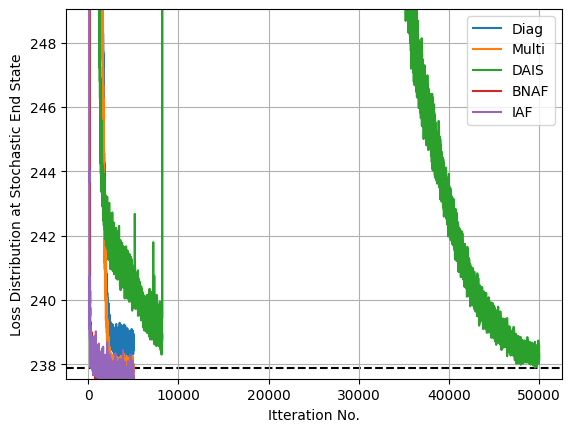

Diag av loss: 	 238.69
Multi av loss: 	 237.89
DAIS av loss: 	 238.36
BNAF av loss: 	 237.52
IAF av loss: 	 237.60


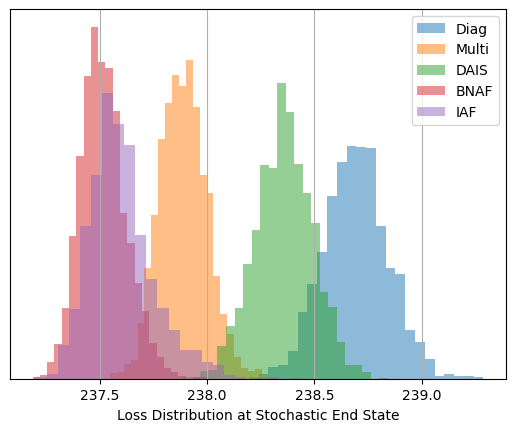

In [36]:
# Collect all results
SVItypes = {}
SVItypes |= {"Diag": [SVI_diagonal_results, 'tab:blue']}
SVItypes |= {"Multi": [SVI_multivariate_results, 'tab:orange']}
SVItypes |= {"DAIS": [SVI_dais_results, 'tab:green']}
SVItypes |= {"BNAF": [SVI_bnaf_results, 'tab:red']}
SVItypes |= {"IAF": [SVI_iaf_results, 'tab:purple']}

#-------------------------
# Loss Convergence Plot
plt.figure()
for name, item in zip(SVItypes.keys(), SVItypes.values()):
    results, color = item[0], item[1]
    plt.plot(results.losses, label = name, c=color)
plt.ylim(0,2000)

plt.legend()
plt.grid()

plt.axhline(SVI_multivariate_results.losses[-num_samples//10:].mean(), c='k', ls='--', zorder=-1)


plt.ylim(ymax=np.min(SVI_multivariate_results.losses)+ np.median(SVI_multivariate_results.losses-np.min(SVI_multivariate_results.losses))*20, ymin=np.min(SVI_multivariate_results.losses))
plt.ylabel("Loss Distribution at Stochastic End State")
plt.xlabel("Itteration No.")

plt.show()

#-------------------------
# Histogram of Final Loss Distributions
plt.figure()
for name, item in zip(SVItypes.keys(), SVItypes.values()):
    results, color = item[0], item[1]
    plt.hist(results.losses[-num_samples//10:], label = name, bins = 24, alpha = 0.5, histtype='stepfilled', density=True)
    print("%s av loss: \t %.2f" %(name,results.losses[-num_samples//10:].mean()))
plt.xlabel("Loss Distribution at Stochastic End State")
plt.yticks([])
plt.legend()
plt.grid()
plt.show()


Now looking at a posterior corner plot for the different methods, we can see how they've managed to adapt much closer to the non-gaussian shapes markedly better than Normal autoguides. Again, DAIS underperforms in this example and hasn't _fully_ converged, but even so it still outperforms the diagonal basis normal guide that it uses as its "base" distribution that it diffuses from.

Pulling results for...
	 m_mu
	 m_sig
	 c_mu
	 c_sig


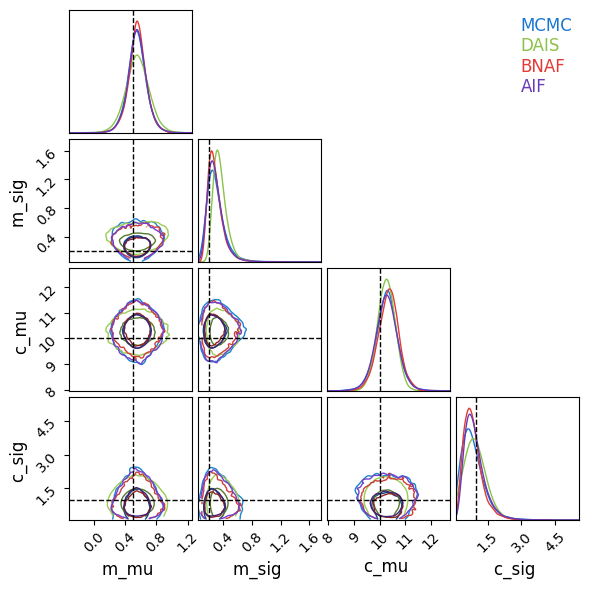

In [37]:
dais_res = {}
bnaf_res = {}
iaf_res = {}

print("Pulling results for...")
daispred = numpyro.infer.Predictive(autoguide_dais, params = SVI_dais_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
bnafpred = numpyro.infer.Predictive(autoguide_bnaf, params = SVI_bnaf_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
iafpred = numpyro.infer.Predictive(autoguide_iaf, params = SVI_iaf_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)

for key in ['m_mu', 'm_sig', 'c_mu', 'c_sig', ]:
    print("\t",key)
    dais_res |= {key: daispred[key]}
    bnaf_res |= {key: bnafpred[key]}
    iaf_res|= {key: iafpred[key]}

C_hierarchy = ChainConsumer()

C_hierarchy.add_chain(mcmc_res, name="MCMC")
C_hierarchy.add_chain(dais_res, name="DAIS")
C_hierarchy.add_chain(bnaf_res, name="BNAF")
C_hierarchy.add_chain(iaf_res, name="AIF")

C_hierarchy.plotter.plot(truth=truth,)

plt.show()
